In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

import torch.nn as nn
import torch.nn.functional as F

import dask
import emcee
import corner

# Sampling Using Annealed Langevin Dynamics

### Example Distribution: Triple Peaked

In [70]:
def log_pi_technically(x, mu1 = 1, mu2 = 2, mu3 = 3, sigma = 0.1):
    #Log of three gaussians: This is actually a logsumexp! PGM flashback :)
    return torch.log(torch.exp(-(x - mu1)**2/(2*sigma**2)) + torch.exp(-(x - mu2)**2/(2*sigma**2)) + torch.exp(-(x - mu3)**2/(2*sigma**2)))

In [71]:
def log_pi(x, mu1 = 1, mu2 = 2, mu3 = 3, sigma = 0.1):
    #Log of three gaussians: Numerically stable
    xs = torch.Tensor([-0.5*(x - mu1)**2/sigma**2, -0.5*(x - mu2)**2/sigma**2, -0.5*(x - mu3)**2/sigma**2])
    a = torch.max(xs)
    return a + torch.log(torch.exp(-(x - mu1)**2/(2*sigma**2) - a) + torch.exp(-(x - mu2)**2/(2*sigma**2) - a) + torch.exp(-(x - mu3)**2/(2*sigma**2) - a))

tensor(0.7520)


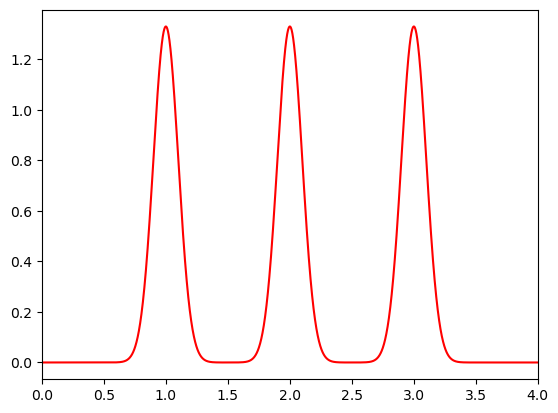

In [72]:
plt.xlim(0, 4)
xs = torch.linspace(0, 4, 5000)
pi = []
for i in range(len(xs)):
    pi.append(torch.exp(log_pi(xs[i])))
norm = torch.trapezoid(torch.Tensor(pi), xs)
print(norm)
plt.plot(xs, np.array(pi)/norm.numpy(), "-r")
plt.show()

### MCMC

In [73]:
def log_pi_np(x, mu1 = 1, mu2 = 2, mu3 = 3, sigma = 0.1):
    #Log of three gaussians: Numerically stable
    xs = np.array([-0.5*(x - mu1)**2/sigma**2, -0.5*(x - mu2)**2/sigma**2, -0.5*(x - mu3)**2/sigma**2])
    a = np.max(xs)
    return a + np.log(np.exp(-(x - mu1)**2/(2*sigma**2) - a) + np.exp(-(x - mu2)**2/(2*sigma**2) - a) + np.exp(-(x - mu3)**2/(2*sigma**2) - a))

In [87]:
nwalkers = 10
ndim = 1
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_pi_np, args=(1, 2, 3, 0.1))

In [88]:
pos = np.array([2]) + 1*np.random.randn(nwalkers, ndim)

In [89]:
sampler.run_mcmc(pos, 3000, progress=True);

100%|█████████████████████████████████████| 3000/3000 [00:01<00:00, 1849.40it/s]


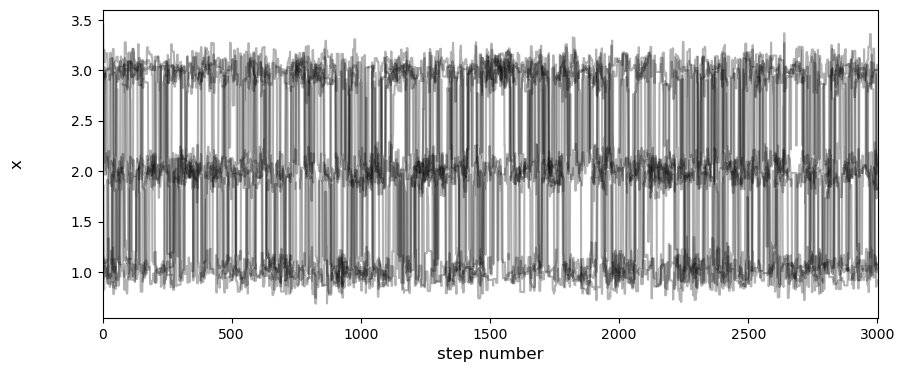

In [90]:
fig, axes = plt.subplots(1, figsize=(10, 4), sharex=True)
samples = sampler.get_chain()
labels = ["x"]
for i in range(ndim):
    ax = axes
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i], fontsize = 12)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes.set_xlabel("step number", fontsize = 12);

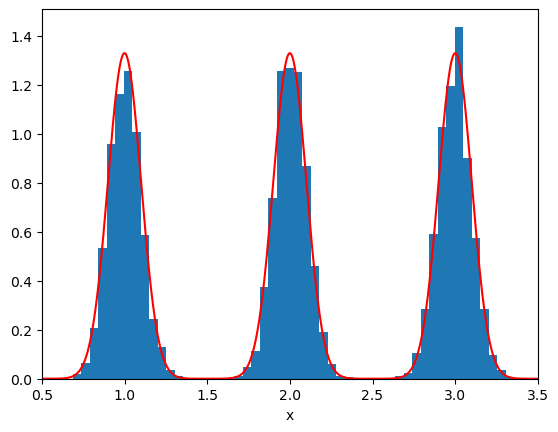

In [92]:
plt.hist(samples.flatten(), bins = int(np.sqrt(3000)), density = True)
plt.xlim(0.5, 3.5)
xs = torch.linspace(0, 4, 5000)
pi = []
for i in range(len(xs)):
    pi.append(torch.exp(log_pi(xs[i])))
norm = torch.trapezoid(torch.Tensor(pi), xs)
plt.plot(xs, np.array(pi)/norm.numpy(), "-r")
plt.xlabel("x")
plt.show()

### Langevin Without Annealing

In [104]:
def unadjusted_langevin_algorithm(potential, n_samples=100000, step=0.1, burn_in = 10000, noise = 1):
    X0 = torch.normal(torch.Tensor([2]), torch.Tensor([1]), out = torch.Tensor([1]))
    Xi = X0
    samples = np.empty(1)
    for i in range(n_samples + burn_in - 1):
        Xi.requires_grad_()
        u = potential(Xi)
        grad = torch.autograd.grad(u, Xi)[0]
        with torch.no_grad():
            Xi = Xi + step*grad + np.sqrt(2 * step) * torch.normal(torch.Tensor([0]), torch.Tensor([noise]), out = torch.Tensor([1]))
            samples = np.append(samples, Xi.numpy())
    return samples[burn_in:]

In [189]:
samples = unadjusted_langevin_algorithm(log_pi, n_samples = 5000, step = 1e-3, burn_in = 1000, noise = 3)

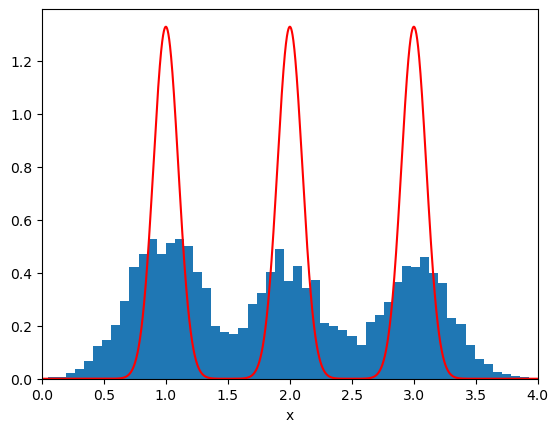

In [192]:
plt.hist(samples, bins = int(np.sqrt(3000)), density = True)
plt.xlim(0, 4)
xs = torch.linspace(0, 4, 5000)
pi = []
for i in range(len(xs)):
    pi.append(torch.exp(log_pi(xs[i])))
norm = torch.trapezoid(torch.Tensor(pi), xs)
plt.plot(xs, np.array(pi)/norm.numpy(), "-r")
plt.xlabel("x")
plt.show()

### Demonstration of Annealing

In [93]:
def log_pi_temp(x, mu1 = 1, mu2 = 2, mu3 = 3, sigma = 0.1, temperature = 0):
    #Log of three gaussians: Numerically stable
    scale = torch.sqrt(torch.Tensor([sigma**2 + temperature**2]))
    xs = torch.Tensor([-(x - mu1)**2/scale**2, -(x - mu2)**2/scale**2, -(x - mu3)**2/scale**2])
    a = torch.max(xs)
    return a + torch.log(torch.exp(-0.5*(x - mu1)**2/scale**2 - a) + torch.exp(-0.5*(x - mu2)**2/scale**2 - a) + torch.exp(-0.5*(x - mu3)**2/scale**2 - a))

/tmp/ipykernel_9850/42679184.py:10: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  plt.plot(xs, np.array(pi)/norm.numpy() + height, "-")
/tmp/ipykernel_9850/42679184.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(xs, np.array(pi)/norm.numpy() + height, "-")


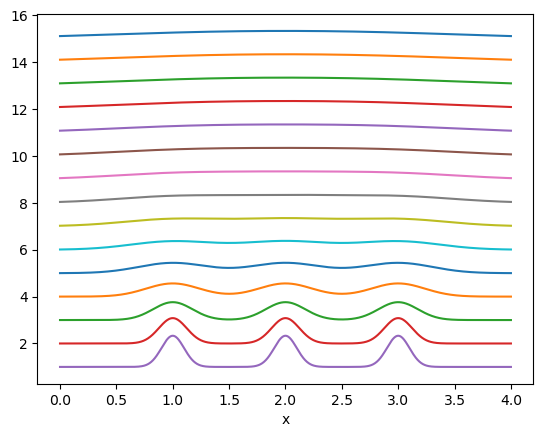

In [96]:
xs = torch.linspace(0, 4, 1000)
temps = torch.linspace(1, 1e-10, 15)
height = 15
for temp in temps:
    pi = []
    for i in range(len(xs)):
        pi.append(torch.exp(log_pi_temp(xs[i], temperature = temp)))
    #print(temp.numpy())
    norm = torch.trapezoid(torch.Tensor(pi), xs)
    plt.plot(xs, np.array(pi)/norm.numpy() + height, "-")
    height -= 1
plt.xlabel("x")
plt.show()

### Langevin + solution to SDE for variance-exploding noise scheduler

In [196]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers = 10)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 10,Total memory: 15.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42349,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 15.37 GiB
Comm: tcp://127.0.0.1:43787,Total threads: 1
Dashboard: http://127.0.0.1:36511/status,Memory: 1.54 GiB
Nanny: tcp://127.0.0.1:46679,


In [197]:
sigma_min = 1e-8
sigma_max = 100
def sigma(t):
    return sigma_min * (sigma_max / sigma_min)**t
def g(t):
    return sigma(t) * np.sqrt(2 * (np.log(sigma_max) - np.log(sigma_min)))

In [217]:
sigma(0.2)

1.0000000000000004e-06

In [213]:
def log_pi_temp(x, mu1 = 1, mu2 = 2, mu3 = 3, sigma = 0.1, temperature = 0):
    #Log of three gaussians: Numerically stable
    scale = torch.sqrt(torch.Tensor([sigma**2 + temperature**2]))
    xs = torch.Tensor([-0.5*(x - mu1)**2/scale**2, -0.5*(x - mu2)**2/scale**2, -0.5*(x - mu3)**2/scale**2])
    a = torch.max(xs)
    return a + torch.log(torch.exp(-0.5*(x - mu1)**2/scale**2 - a) + torch.exp(-0.5*(x - mu2)**2/scale**2 - a) + torch.exp(-0.5*(x - mu3)**2/scale**2 - a))

@dask.delayed
def var_explode_parallel(potential, steps, walkers):
    X0 =  sigma(0.2)*torch.randn(1) + 5 # The ONLY correct "prior" initialization for X0: sample from distribution at max temperature 
    Xi = X0
    dt = -1/steps
    t = 1
    # Iterate over all noise scales ("sigmas")
    for step in range(steps):
        t += dt
        Xi.requires_grad_()
        u = potential(Xi, temperature = sigma(t))
        grad = torch.autograd.grad(u, Xi)[0]
        with torch.no_grad():
            Xi_m = Xi - g(t)**2*grad*dt
            Xi = Xi_m + g(t)*np.sqrt(-dt)*torch.normal(torch.Tensor([0]), torch.Tensor([1]), out = torch.Tensor([1]))
    return Xi_m.numpy()

def walkers_parallel(potential, steps, walkers):
    samples = []
    for j in range(walkers):
        samples.append(var_explode_parallel(potential, steps, walkers))
    results = dask.compute(*samples)
    return results

In [214]:
samples_list = walkers_parallel(log_pi_temp, 200, 3000)

In [215]:
samples = samples_list[0]
for i in range(len(samples_list)):
    samples = np.append(samples, samples_list[i])

/tmp/ipykernel_9850/4269080009.py:8: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  plt.plot(xs, np.array(pi)/norm.numpy(), "-r")
/tmp/ipykernel_9850/4269080009.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(xs, np.array(pi)/norm.numpy(), "-r")


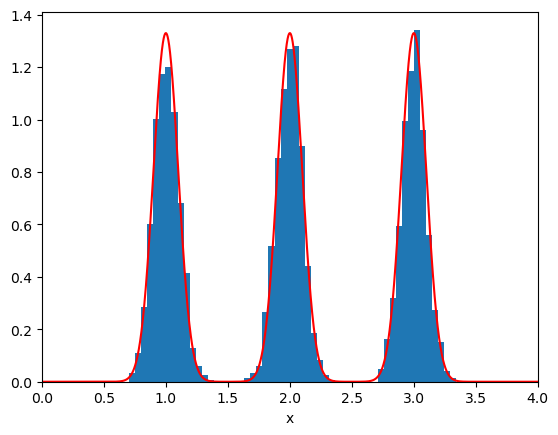

In [216]:
plt.hist(samples, bins = int(np.sqrt(3000)), density = True)
plt.xlim(0, 4)
xs = torch.linspace(0, 4, 5000)
pi = []
for i in range(len(xs)):
    pi.append(torch.exp(log_pi_temp(xs[i], temperature = 0)))#temperature = sigma(0.9))))
norm = torch.trapezoid(torch.Tensor(pi), xs)
plt.plot(xs, np.array(pi)/norm.numpy(), "-r")
plt.xlabel("x")
plt.show()

### Posterior Samples Using Langevin

In [249]:
sigma_min = 1e-8
sigma_max = 100
def sigma(t):
    return sigma_min * (sigma_max / sigma_min)**t
def g(t):
    return sigma(t) * np.sqrt(2 * (np.log(sigma_max) - np.log(sigma_min)))

In [259]:
def log_pi_temp(x, mu1 = 1, mu2 = 2, mu3 = 3, sigma = 0.1, temperature = 0):
    #Log of three gaussians: Numerically stable
    scale = torch.sqrt(torch.Tensor([sigma**2 + temperature**2]))
    xs = torch.Tensor([-0.5*(x - mu1)**2/scale**2, -0.5*(x - mu2)**2/scale**2, -0.5*(x - mu3)**2/scale**2])
    a = torch.max(xs)
    return a + torch.log(torch.exp(-0.5*(x - mu1)**2/scale**2 - a) + torch.exp(-0.5*(x - mu2)**2/scale**2 - a) + torch.exp(-0.5*(x - mu3)**2/scale**2 - a))

@dask.delayed
def var_explode_parallel(potential, steps, walkers):
    X0 =  sigma(1)*torch.randn(1) + 2 # The ONLY correct "prior" initialization for X0: sample from distribution at max temperature 
    Xi = X0
    dt = -1/steps
    t = 1
    # Iterate over all noise scales ("sigmas")
    for step in range(steps):
        t += dt
        Xi.requires_grad_()
        u = potential(Xi, temperature = sigma(t))
        grad = torch.autograd.grad(u, Xi)[0]
        with torch.no_grad():
            Xi_m = Xi - g(t)**2*grad*dt
            Xi = Xi_m + g(t)*np.sqrt(-dt)*torch.normal(torch.Tensor([0]), torch.Tensor([1]), out = torch.Tensor([1]))
    return Xi_m.numpy()

def walkers_parallel(potential, steps, walkers):
    samples = []
    for j in range(walkers):
        samples.append(var_explode_parallel(potential, steps, walkers))
    results = dask.compute(*samples)
    return results

In [260]:
def forward(x):
    return x#torch.sin(x)

In [261]:
def post(x, temperature):
    y = forward(3.3*torch.ones(1))
    sigma_noise = 1e-1
    #temperature_likelihood = temperature*torch.sqrt((torch.cos(x))**2)
    noise = torch.sqrt(torch.Tensor([sigma_noise**2 + temperature**2]))
    return -0.5*torch.sum((y-forward(x))**2/noise**2) + log_pi_temp(x, temperature = temperature)

def like(x, temperature):
    y = forward(3.3*torch.ones(1))
    sigma_noise = 1e-1
    #temperature_likelihood = temperature*torch.sqrt((torch.cos(x))**2)
    noise = torch.sqrt(torch.Tensor([sigma_noise**2 + temperature**2]))
    return -0.5*torch.sum((y-forward(x))**2/noise**2)# + log_pi_temp(x, temperature = temperature)

In [262]:
samples_list = walkers_parallel(post, 200, 1000)

In [263]:
samples = samples_list[0]
for i in range(len(samples_list)):
    samples = np.append(samples, samples_list[i])

In [264]:
samples[0:20]

array([3.1544821, 3.1544821, 3.145162 , 3.1400945, 3.1363685, 3.155098 ,
       3.2240608, 3.010481 , 3.1371386, 3.2728667, 3.1860108, 3.0526447,
       3.2075186, 3.1183379, 3.1137133, 3.2107415, 3.2099543, 3.128797 ,
       3.1405683, 2.9607894], dtype=float32)

/tmp/ipykernel_9850/4259281475.py:9: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  plt.plot(xs, np.array(pi)/norm.numpy(), "-k", label = "True Posterior")
/tmp/ipykernel_9850/4259281475.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.plot(xs, np.array(pi)/norm.numpy(), "-k", label = "True Posterior")
/tmp/ipykernel_9850/4259281475.py:21: FutureWarning: The i

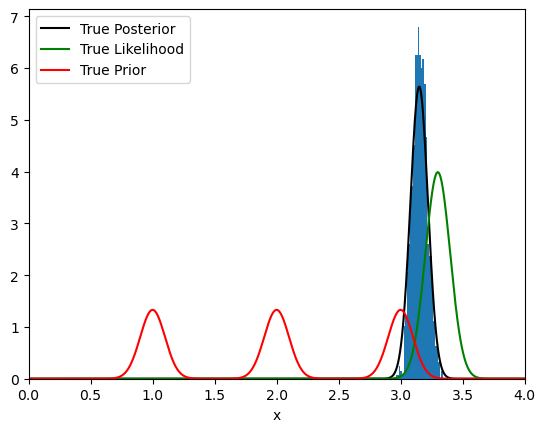

In [266]:
plt.hist(samples, bins = 30, density = True)
plt.xlim(0, 4)
#plt.ylim(0, 30)
xs = torch.linspace(0, 5, 10000)
pi = []
for i in range(len(xs)):
    pi.append(torch.exp(post(xs[i], temperature = 0)))
norm = torch.trapezoid(torch.Tensor(pi), xs)
plt.plot(xs, np.array(pi)/norm.numpy(), "-k", label = "True Posterior")
#plt.plot(xs, normal.pdf(xs, loc = 2., scale = 100))
pi = []
for i in range(len(xs)):
    pi.append(torch.exp(like(xs[i], temperature = 0)))
norm = torch.trapezoid(torch.Tensor(pi), xs)
plt.plot(xs, np.array(pi)/norm.numpy(), "-g", label = "True Likelihood")
#plt.plot(xs, normal.pdf(xs, loc = 2., scale = 100))
pi = []
for i in range(len(xs)):
    pi.append(torch.exp(log_pi_temp(xs[i], temperature = 0)))#temperature = sigma(0.9))))
norm = torch.trapezoid(torch.Tensor(pi), xs)
plt.plot(xs, np.array(pi)/norm.numpy(), "-r", label = "True Prior")
plt.xlabel("x")
plt.legend()
plt.show()

# Sersic Model for Galaxy

### Numpy

In [459]:
def sersic2D(x, y, amplitude, r_eff, n, bn, x_0, y_0, ellip, theta):
    """Two dimensional Sersic profile function."""
    a, b = r_eff, (1 - ellip) * r_eff
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    x_maj = (x - x_0) * cos_theta + (y - y_0) * sin_theta
    x_min = -(x - x_0) * sin_theta + (y - y_0) * cos_theta
    z = np.sqrt((x_maj / a) ** 2 + (x_min / b) ** 2)

    return amplitude * np.exp(-bn * (z ** (1 / n) - 1))

In [460]:
from scipy.special import gammaincinv

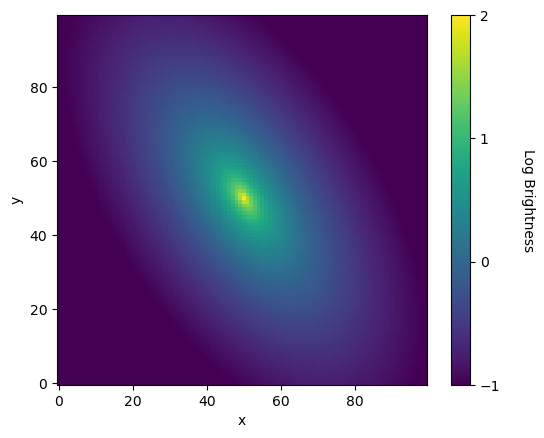

In [461]:
x,y = np.meshgrid(np.arange(100), np.arange(100))
n = 4
bn = gammaincinv(2.0 * n, 0.5)
img = sersic2D(x, y, amplitude = 1, r_eff = 25, n=n, bn = bn, x_0=50, y_0=50,
               ellip=.5, theta=-1)
log_img = np.log10(img)

plt.figure()
plt.imshow(log_img, origin='lower', interpolation='nearest',
           vmin=-1, vmax=2)
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('Log Brightness', rotation=270, labelpad=25)
cbar.set_ticks([-1, 0, 1, 2])
plt.show()

### PyTorch (no differentiable gammaincinv yet, so need to calculate it outside)

In [462]:
def sersic2D(x, y, amplitude, r_eff, n, bn, x_0, y_0, ellip, theta):
    """Two dimensional Sersic profile function."""
    a, b = r_eff, (1 - ellip) * r_eff
    cos_theta, sin_theta = torch.cos(theta), torch.sin(theta)
    x_maj = (x - x_0) * cos_theta + (y - y_0) * sin_theta
    x_min = -(x - x_0) * sin_theta + (y - y_0) * cos_theta
    z = torch.sqrt((x_maj / a) ** 2 + (x_min / b) ** 2)

    return amplitude * torch.exp(-bn * (z ** (1 / n) - 1))

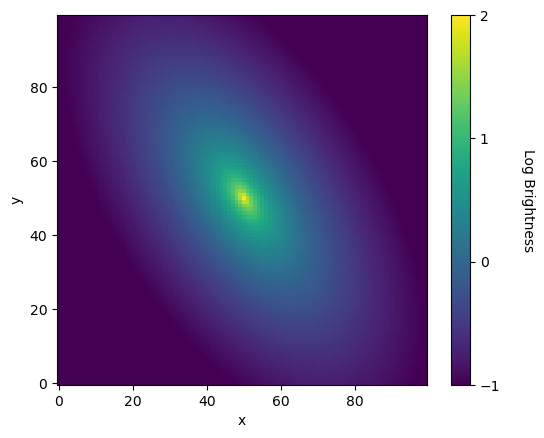

In [463]:
x,y = torch.meshgrid(torch.arange(100), torch.arange(100), indexing = "xy")
n = 4
bn = gammaincinv(2.0 * n, 0.5)
_t = torch.ones([1])
amplitude = 1*_t
r_eff = 25*_t
n = n*_t
bn = bn*_t
x_0 = 50*_t
y_0 = 50*_t
ellip = .5*_t
theta = -1*_t
img = sersic2D(x, y, amplitude = amplitude, r_eff = r_eff, n=n, bn = bn, x_0=x_0, y_0=y_0,
               ellip=ellip, theta=theta)
log_img = torch.log10(img)

plt.figure()
plt.imshow(log_img.numpy(), origin = "lower", interpolation='nearest',
           vmin=-1, vmax=2)
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('Log Brightness', rotation=270, labelpad=25)
cbar.set_ticks([-1, 0, 1, 2])
plt.show()

# Lensing Simulator

In [464]:
def f_p(f):
    return torch.sqrt(1-f**2)
def delta(phi, f):
    return torch.sqrt(torch.cos(phi)**2 + f**2*torch.sin(phi)**2)
def b(r, phi, f):
    return r*delta(phi, f)
def deflection_potential(f, x, y, x_0, y_0):
    r = torch.sqrt((x-x_0)**2 + (y-y_0)**2)
    phi = torch.atan2((y-y_0), (x-x_0))
    term1 = (torch.sqrt(f)/f_p(f))*r
    term2 = torch.sin(phi)*torch.asin(f_p(f)*torch.sin(phi)) + torch.cos(phi)*torch.asinh(f_p(f)/f*torch.cos(phi))
    return term1*term2
def img_pos(f, x, y, x_0, y_0):
    # Returns the source-plane position of image coords x, y
    r = torch.sqrt((x - x_0)**2 + (y - y_0)**2)
    phi = torch.atan2((y - y_0), (x - x_0))
    factor = 10
    x_prime = x - factor*(torch.sqrt(f)/f_p(f))*(torch.asinh(f_p(f)/f*torch.cos(phi))) 
    y_prime = y - factor*(torch.sqrt(f)/f_p(f))*(torch.asin(f_p(f)*torch.sin(phi))) 
    return x_prime, y_prime

In [465]:
img_x, img_y = torch.meshgrid(torch.linspace(0, 100, 200), torch.linspace(0, 100, 200), indexing = "xy")

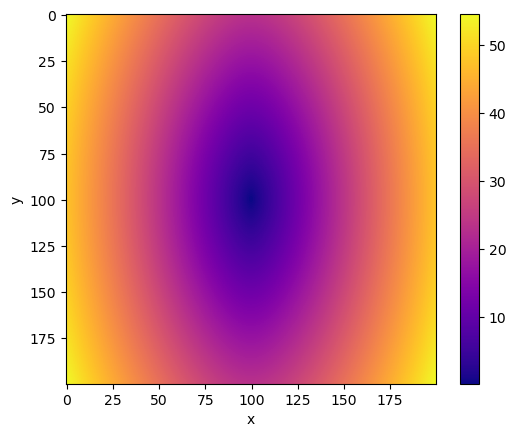

In [466]:
phi = deflection_potential(torch.Tensor([0.1]), img_x, img_y, x_0 = 50, y_0 = 50)
plt.imshow(phi.numpy(), cmap = "plasma")
#plt.xticks([])
#plt.yticks([])
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.show()

# Simulating a Lensed Sersic

In [467]:
lensed_img_x, lensed_img_y = img_pos(torch.Tensor([0.99]), img_x, img_y, x_0 = 50, y_0 = 50)
x_0 = 48*_t
y_0 = 48*_t
lensed_sersic = sersic2D(lensed_img_x, lensed_img_y, amplitude = amplitude, r_eff = r_eff, n=n, bn = bn, x_0=x_0, y_0=y_0,
               ellip=ellip, theta=theta)
sersic_unlensed = sersic2D(img_x, img_y, amplitude = amplitude, r_eff = r_eff, n=n, bn = bn, x_0=x_0, y_0=y_0,
               ellip=ellip, theta=theta)
log_img_lensed = torch.log10(lensed_sersic)
log_img = torch.log10(sersic_unlensed)

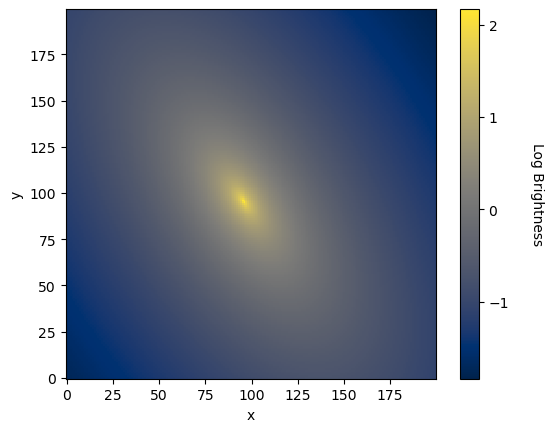

In [468]:
plt.figure()
plt.imshow(log_img.numpy(), origin = "lower", interpolation='nearest', cmap = "cividis")
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('Log Brightness', rotation=270, labelpad=25)
cbar.set_ticks([-1, 0, 1, 2])
plt.show()

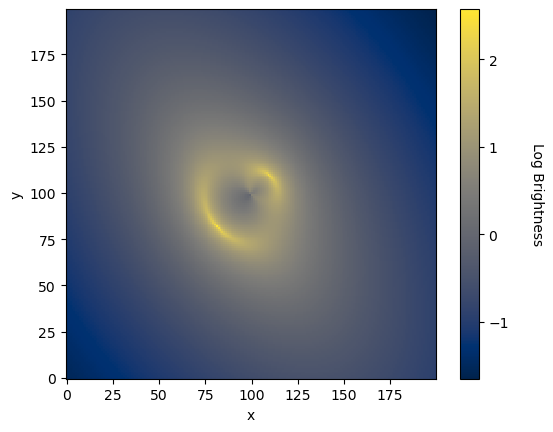

In [469]:
plt.figure()
plt.imshow(log_img_lensed.numpy(), origin = "lower", interpolation='nearest', cmap = "cividis")
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('Log Brightness', rotation=270, labelpad=25)
cbar.set_ticks([-1, 0, 1, 2])
plt.show()

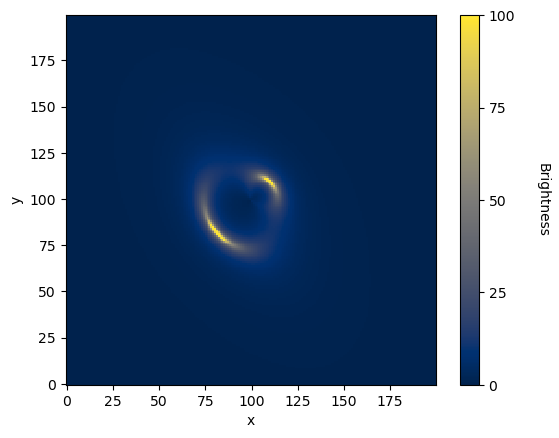

In [529]:
plt.figure()
plt.imshow(lensed_sersic.numpy(), origin = "lower", interpolation='nearest', cmap = "cividis", vmax = 100)
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('Brightness', rotation=270, labelpad=25)
cbar.set_ticks(np.linspace(0, 100, 5))
plt.show()

In [525]:
torch.sqrt(lensed_sersic.mean())

tensor(1.3029)

In [526]:
noisy_lensed_sersic = lensed_sersic + torch.normal(torch.zeros_like(lensed_sersic), 1)
log_img_noisy = torch.log10(noisy_lensed_sersic)

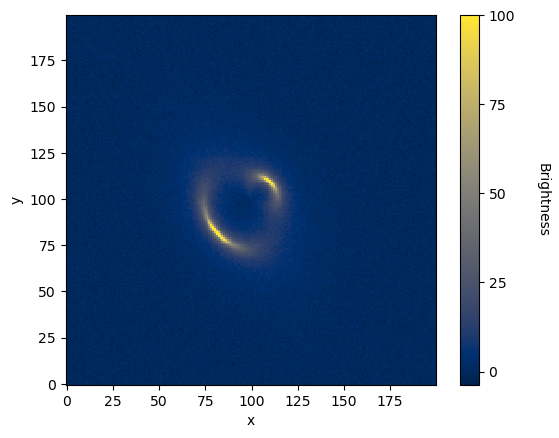

In [528]:
plt.figure()
plt.imshow(noisy_lensed_sersic.numpy(), origin = "lower", interpolation='nearest', cmap = "cividis", vmax = 100)
plt.xlabel('x')
plt.ylabel('y')
cbar = plt.colorbar()
cbar.set_label('Brightness', rotation=270, labelpad=25)
cbar.set_ticks(np.linspace(0, 100, 5))
plt.show()

# Likelihood

In [590]:
n = 4
bn = gammaincinv(2.0 * n, 0.5)
amplitude = 1
r_eff = 25
n = n
bn = bn
ellip = .5
theta = -1
def sersic2D_np(x, y, amplitude, r_eff, n, bn, x_0, y_0, ellip, theta):
    """Two dimensional Sersic profile function."""
    a, b = r_eff, (1 - ellip) * r_eff
    cos_theta, sin_theta = np.cos(theta), np.sin(theta)
    x_maj = (x - x_0) * cos_theta + (y - y_0) * sin_theta
    x_min = -(x - x_0) * sin_theta + (y - y_0) * cos_theta
    z = np.sqrt((x_maj / a) ** 2 + (x_min / b) ** 2)

    return amplitude * np.exp(-bn * (z ** (1 / n) - 1))

In [591]:
def f_p(f):
    return torch.sqrt(1-f**2)
def delta(phi, f):
    return torch.sqrt(torch.cos(phi)**2 + f**2*torch.sin(phi)**2)
def b(r, phi, f):
    return r*delta(phi, f)
def img_pos(f, x, y, x_0, y_0):
    # Returns the source-plane position of image coords x, y
    r = torch.sqrt((x - x_0)**2 + (y - y_0)**2)
    phi = torch.atan2((y - y_0), (x - x_0))
    factor = 10
    x_prime = x - factor*(torch.sqrt(f)/f_p(f))*(torch.asinh(f_p(f)/f*torch.cos(phi))) 
    y_prime = y - factor*(torch.sqrt(f)/f_p(f))*(torch.asin(f_p(f)*torch.sin(phi))) 
    return x_prime, y_prime


def f_p_np(f):
    return np.sqrt(1-f**2)
def img_pos_np(f, x, y, x_0, y_0):
    # Returns the source-plane position of image coords x, y
    r = np.sqrt((x - x_0)**2 + (y - y_0)**2)
    phi = np.arctan2((y - y_0), (x - x_0))
    factor = 10
    x_prime = x - factor*(np.sqrt(f)/f_p_np(f))*(np.arcsinh(f_p_np(f)/f*np.cos(phi))) 
    y_prime = y - factor*(np.sqrt(f)/f_p_np(f))*(np.arcsin(f_p_np(f)*np.sin(phi))) 
    return x_prime, y_prime

In [592]:
def llike_np(x, y, img, img_x, img_y):
    img_flat = img.flatten()
    lensed_img_x, lensed_img_y = img_pos_np(0.99, img_x, img_y, x_0 = 50, y_0 = 50)
    x_0 = x
    y_0 = y
    lensed_sersic = sersic2D_np(lensed_img_x, lensed_img_y, amplitude = amplitude, r_eff = r_eff, n=n, bn = bn, x_0=x_0, y_0=y_0,
               ellip=ellip, theta=theta)
    noisy_lensed_sersic = lensed_sersic + 3*np.random.randn(lensed_sersic.shape[0], lensed_sersic.shape[1])
    noisy_flat = noisy_lensed_sersic.flatten()
    return np.sum(-0.5*(img_flat - noisy_flat)**2/1**2)

# Prior

In [593]:
def l_prior(x, y):
    return -0.5*(x-50)**2/5**2 + -0.5*(y-50)**2/5**2

# Unnormalized Posterior

In [594]:
def post_np(xy, img, img_x, img_y):
    x, y = xy[0], xy[1]
    return l_prior(x, y) + llike_np(x, y, img, img_x, img_y)

# Sampling with emcee MCMC

In [595]:
img_x, img_y = np.meshgrid(np.linspace(0, 100, 200), np.linspace(0, 100, 200), indexing = "xy")

In [596]:
nwalkers = 10
ndim = 2
sampler = emcee.EnsembleSampler(nwalkers, ndim, post_np, args=(noisy_lensed_sersic.numpy(), img_x, img_y))

In [597]:
pos = np.array([50]) + 1*np.random.randn(nwalkers, ndim)

In [598]:
sampler.run_mcmc(pos, 1000, progress=True);

100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 49.55it/s]


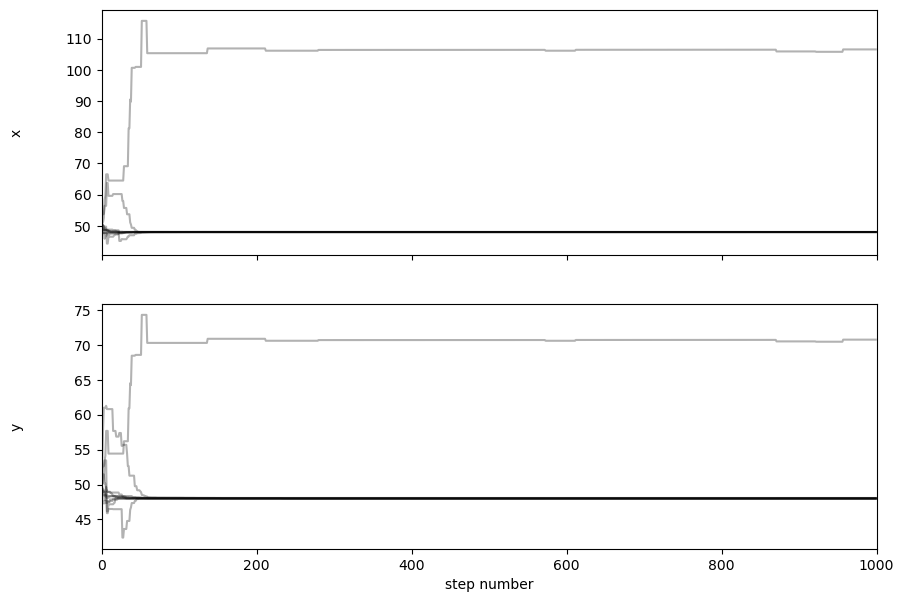

In [599]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["x", "y"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [600]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [14.9756427  21.06005081]

In [631]:
flat_samples = sampler.get_chain(discard=100, flat=True)
print(flat_samples.shape)

(9000, 2)


In [632]:
flat_samples_outliers_cleaned = flat_samples[:, 0][np.logical_and(flat_samples[:, 0] > 45, flat_samples[:, 0] < 48.3)]

In [633]:
flat_samples_outliers_cleaned.shape

(8100,)

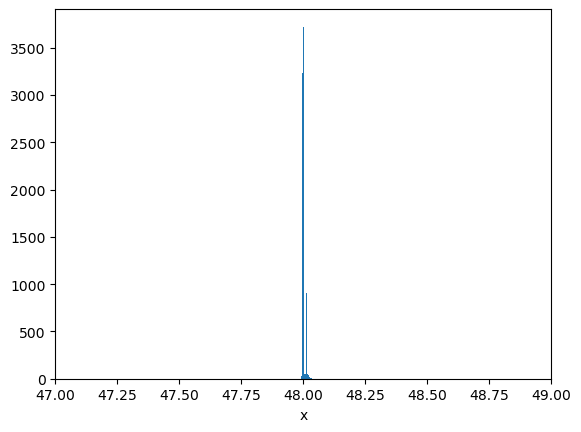

In [634]:
plt.hist(flat_samples_outliers_cleaned, bins = 10, density = False)
plt.xlim(47, 49)
plt.xlabel("x")
plt.show()

In [635]:
flat_samples_outliers_cleaned = flat_samples[:, 1][np.logical_and(flat_samples[:, 1] > 45, flat_samples[:, 1] < 55)]

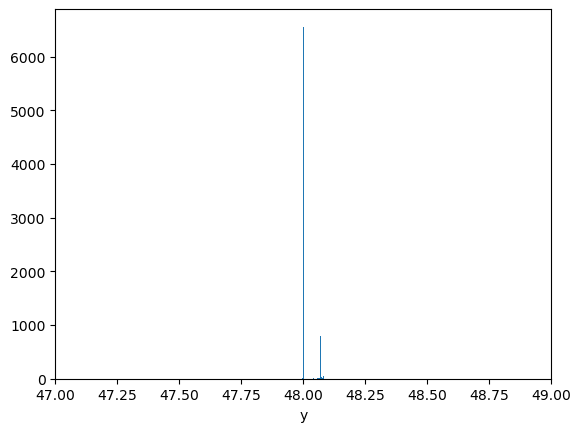

In [638]:
plt.hist(flat_samples_outliers_cleaned, bins = 50, density = False)
plt.xlim(47, 49)
plt.xlabel("y")
plt.show()

In [551]:
np.median(flat_samples[:, 0])

47.98991467604764

In [552]:
np.median(flat_samples[:, 1])

48.0057965202644

# Same thing but now in Pytorch + Annealed Langevin sampling

In [64]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers = 10)
client = Client(cluster)
client

2023-04-28 20:25:04,611 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-fuxbcnx0', purging
2023-04-28 20:25:04,612 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-0zjdw6d9', purging
2023-04-28 20:25:04,612 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-eysvs87t', purging
2023-04-28 20:25:04,612 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-gbzvpot0', purging
2023-04-28 20:25:04,613 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-glwt_76w', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 10,Total memory: 15.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40965,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 15.37 GiB
Comm: tcp://127.0.0.1:44143,Total threads: 1
Dashboard: http://127.0.0.1:38199/status,Memory: 1.54 GiB
Nanny: tcp://127.0.0.1:41811,


In [606]:
n = 4
bn = gammaincinv(2.0 * n, 0.5)
_t = torch.ones([1])
amplitude = 1*_t
r_eff = 25*_t
n = n*_t
bn = bn*_t
ellip = .5*_t
theta = -1*_t
def sersic2D(x, y, amplitude, r_eff, n, bn, x_0, y_0, ellip, theta):
    """Two dimensional Sersic profile function."""
    a, b = r_eff, (1 - ellip) * r_eff
    cos_theta, sin_theta = torch.cos(theta), torch.sin(theta)
    x_maj = (x - x_0) * cos_theta + (y - y_0) * sin_theta
    x_min = -(x - x_0) * sin_theta + (y - y_0) * cos_theta
    z = torch.sqrt((x_maj / a) ** 2 + (x_min / b) ** 2)

    return amplitude * torch.exp(-bn * (z ** (1 / n) - 1))

In [607]:
def f_p(f):
    return torch.sqrt(1-f**2)
def delta(phi, f):
    return torch.sqrt(torch.cos(phi)**2 + f**2*torch.sin(phi)**2)
def b(r, phi, f):
    return r*delta(phi, f)
def img_pos(f, x, y, x_0, y_0):
    # Returns the source-plane position of image coords x, y
    r = torch.sqrt((x - x_0)**2 + (y - y_0)**2)
    phi = torch.atan2((y - y_0), (x - x_0))
    factor = 10
    x_prime = x - factor*(torch.sqrt(f)/f_p(f))*(torch.asinh(f_p(f)/f*torch.cos(phi))) 
    y_prime = y - factor*(torch.sqrt(f)/f_p(f))*(torch.asin(f_p(f)*torch.sin(phi))) 
    return x_prime, y_prime

In [608]:
def llike(x, y, img, img_x, img_y, temperature):
    img_flat = img.flatten()
    lensed_img_x, lensed_img_y = img_pos(torch.Tensor([0.99]), img_x, img_y, x_0 = 50, y_0 = 50)
    x_0 = x
    y_0 = y
    #print(img_flat.shape)
    lensed_sersic = sersic2D(lensed_img_x, lensed_img_y, amplitude = amplitude, r_eff = r_eff, n=n, bn = bn, x_0=x_0, y_0=y_0,
               ellip=ellip, theta=theta)
    noisy_lensed_sersic_f = lensed_sersic# + torch.normal(torch.zeros_like(lensed_sersic), 1)
    noisy_flat = noisy_lensed_sersic_f.flatten()
    #print(noisy_flat.shape)
    sigma = torch.sqrt(torch.Tensor([temperature**2 + 1**2]))
    return torch.sum(-0.5*(img_flat - noisy_flat)**2/sigma**2)

In [609]:
def l_prior(x, y, temperature):
    sigma = torch.sqrt(torch.Tensor([temperature**2 + 1**2]))
    return -0.5*(x-50)**2/sigma**2 + -0.5*(y-50)**2/sigma**2

In [610]:
img_x, img_y = torch.meshgrid(torch.linspace(0, 100, 200), torch.linspace(0, 100, 200), indexing = "xy")

In [611]:
def post(xy, img, img_x, img_y, temperature):
    x, y = xy[0], xy[1]
    return l_prior(x, y, temperature) + llike(x, y, img, img_x, img_y, temperature)

In [640]:
sigma(.01)

0.0010964781961431851

In [612]:
sigma_min = 1e-3
sigma_max = 10
def sigma(t):
    return sigma_min * (sigma_max / sigma_min)**t
def g(t):
    return sigma(t) * np.sqrt(2 * (np.log(sigma_max) - np.log(sigma_min)))

In [613]:
@dask.delayed
def var_explode_parallel(potential, steps, walkers):
    X0 =  sigma(0.01)*torch.randn(2) + 48 # The ONLY correct "prior" initialization for X0: sample from distribution at max temperature 
    Xi = X0
    dt = -1/steps
    t = 1
    # Iterate over all noise scales ("sigmas")
    for step in range(steps):
        t += dt
        Xi.requires_grad_()
        u = potential(Xi, noisy_lensed_sersic, img_x, img_y, temperature = sigma(t))
        grad = torch.autograd.grad(u, Xi)[0]
        with torch.no_grad():
            Xi_m = Xi - g(t)**2*grad*dt
            Xi = Xi_m + g(t)*np.sqrt(-dt)*torch.normal(torch.Tensor([0, 0]), torch.Tensor([1, 1]), out = torch.Tensor([1, 1]))
    return Xi_m.numpy()

def walkers_parallel(potential, steps, walkers):
    samples = []
    for j in range(walkers):
        samples.append(var_explode_parallel(potential, steps, walkers))
    results = dask.compute(*samples)
    return results

In [614]:
samples_list = walkers_parallel(post, 500, 500)

In [615]:
samples_list[0:10]

(array([ 0.5494582, 74.73859  ], dtype=float32),
 array([28.293959, 99.352615], dtype=float32),
 array([66.88604  ,  1.7557262], dtype=float32),
 array([ 42.980946, -80.412766], dtype=float32),
 array([-3.6805496, 18.062822 ], dtype=float32),
 array([66.958374 ,  1.7888881], dtype=float32),
 array([ 32.223392, -63.17041 ], dtype=float32),
 array([67.02891  ,  1.7523651], dtype=float32),
 array([28.755278, 99.22155 ], dtype=float32),
 array([66.96955  ,  1.8163542], dtype=float32))

In [616]:
samples = samples_list[0].reshape(2, 1)
for i in range(len(samples_list)):
    samples = np.append(samples, samples_list[i].reshape(2, 1), axis = 1)

In [617]:
samples.shape

(2, 501)

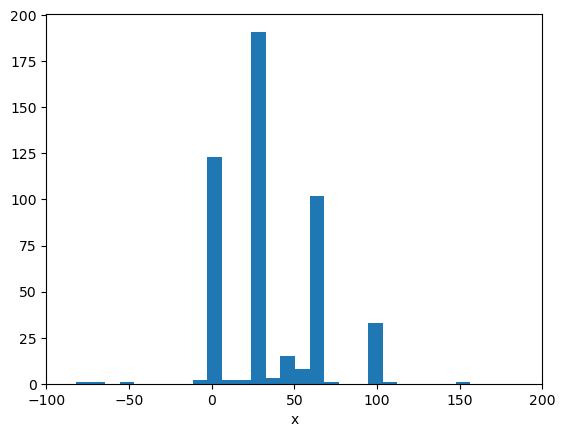

In [623]:
plt.hist(samples[0], bins = 1000, density = False)
plt.xlabel("x")
plt.xlim(-100, 200)
plt.show()

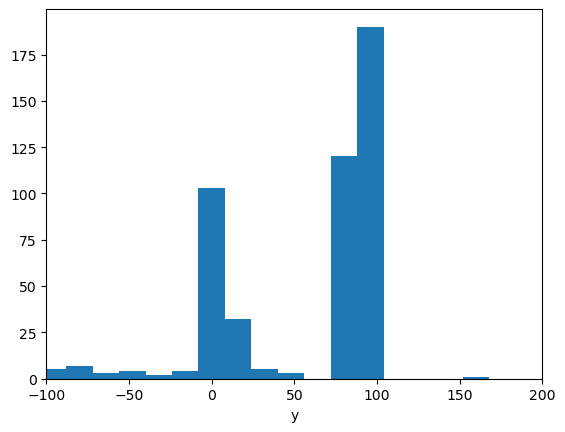

In [639]:
plt.hist(samples[1], bins = 1000, density = False)
plt.xlabel("y")
plt.xlim(-100, 200)
plt.show()

In [620]:
np.mean(samples[1])

74.619835